[[1.    0.75  1.   ]
 [1.    0.75  1.   ]
 [1.    0.75  1.   ]
 ...
 [0.125 0.    0.1  ]
 [0.125 0.    0.1  ]
 [0.125 0.    0.1  ]]
Steps:  0 ; Time:  0.0
Steps:  1 ; Time:  0.0008276364544380624
Steps:  2 ; Time:  0.0015056590123360251
Steps:  3 ; Time:  0.0021826294575816333
Steps:  4 ; Time:  0.0028180101350889467
Steps:  5 ; Time:  0.0034516527486030965
Steps:  6 ; Time:  0.004075822389813245
Steps:  7 ; Time:  0.004694782513953081
Steps:  8 ; Time:  0.0053133555603342856
Steps:  9 ; Time:  0.005925128573783541
Steps:  10 ; Time:  0.0065384424150343665
Steps:  11 ; Time:  0.0071458293693554085
Steps:  12 ; Time:  0.007751087709662803
Steps:  13 ; Time:  0.00835546310202729
Steps:  14 ; Time:  0.008956056845507964
Steps:  15 ; Time:  0.009558209022272387
Steps:  16 ; Time:  0.010155848643195253
Steps:  17 ; Time:  0.010753094766835464
Steps:  18 ; Time:  0.011348767726287071
Steps:  19 ; Time:  0.011942771223454132
Steps:  20 ; Time:  0.012537035081226637
Steps:  21 ; Time:  0.01312

Steps:  202 ; Time:  0.11866362566266478
Steps:  203 ; Time:  0.11924606083348624
Steps:  204 ; Time:  0.1198284958777085
Steps:  205 ; Time:  0.12041093082764949
Steps:  206 ; Time:  0.12099336570159988
Steps:  207 ; Time:  0.12157580048544234
Steps:  208 ; Time:  0.12215823515815635
Steps:  209 ; Time:  0.12274066973393034
Steps:  210 ; Time:  0.12332310419921237
Steps:  211 ; Time:  0.12390553858273981
Steps:  212 ; Time:  0.12448797289975601
Steps:  213 ; Time:  0.12507040709606454
Steps:  214 ; Time:  0.12565284119103767
Steps:  215 ; Time:  0.12623527521125696
Steps:  216 ; Time:  0.1268177091641884
Steps:  217 ; Time:  0.12740014302596686
Steps:  218 ; Time:  0.127982576794213
Steps:  219 ; Time:  0.12856501047400073
Steps:  220 ; Time:  0.12914744406430162
Steps:  221 ; Time:  0.12972987758876703
Steps:  222 ; Time:  0.13031231103078555
Steps:  223 ; Time:  0.1308947443719195
Steps:  224 ; Time:  0.13147717763040953
Steps:  225 ; Time:  0.13205961082814316
Steps:  226 ; Time:  

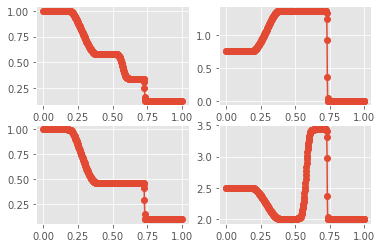

In [4]:
import numpy as np
np.seterr(all='raise')
GAMMA = 1.4

def w2u(w):
    """
    Convert the primitive to conservative variables.
    """
    u = np.zeros(3)
    u[0] = w[0]
    u[1] = w[0]*w[1]
    u[2] = w[2]/(GAMMA-1.0)+0.5*w[0]*w[1]*w[1]
    return u

def u2w(u):
    """
    Convert the conservative to primitive variables.
    """
    w = np.zeros(3)
    w[0] = u[0]
    w[1] = u[1]/u[0]
    w[2] = (GAMMA-1.0)*( u[2] - 0.5*w[0]*w[1]*w[1] )
    return w

def euler_flux(w):
    """
    Calculate the conservative Euler fluxes.
    """
    rho = w[0]
    u = w[1]
    p = w[2]

    a2 = GAMMA*p/rho

    f_1 = rho*u
    f_2 = rho*u*u + p
    f_3 = rho*u*( a2/(GAMMA-1.0) + 0.5*u*u )

    return np.array([f_1, f_2, f_3])

def roe_flux(wL, wR):
    """
    Use the Roe approximate Riemann solver to calculate fluxes.
    """
    uL = w2u(wL)
    uR = w2u(wR)

    # Primitive and other variables.
    # Left state
    rhoL = wL[0]
    vL = wL[1]
    pL = wL[2]
    aL = np.sqrt(GAMMA*pL/rhoL)
    HL = ( uL[2] + pL ) / rhoL

    # Right state
    rhoR = wR[0]
    vR = wR[1]
    pR = wR[2]
    aR = np.sqrt(GAMMA*pR/rhoR)
    HR = ( uR[2] + pR ) / rhoR

    # First compute the Roe Averages
    # Refer to Toro2009, P356
    RT = np.sqrt(rhoR/rhoL);
    rho = RT*rhoL
    v = (vL+RT*vR)/(1.0+RT)
    H = (HL+RT*HR)/(1.0+RT)
    a = np.sqrt( (GAMMA-1.0)*(H-0.5*v*v) )

    # Differences in primitive variables.
    drho = rhoR - rhoL
    du = vR - vL
    dP = pR - pL

    # Wave strength (Characteristic Variables).
    # The following lines can also be in the form referred to Toro2009, P357.
    dV = np.array([0.0,0.0,0.0])
    dV[0] = 0.5*(dP-rho*a*du)/(a*a)
    dV[1] = -( dP/(a*a) - drho )
    dV[2] = 0.5*(dP+rho*a*du)/(a*a)

    # Absolute values of the wave speeds (Eigenvalues)
    ws = np.array([0.0,0.0,0.0])
    ws[0] = abs(v-a)
    ws[1] = abs(v)
    ws[2] = abs(v+a)

    # Modified wave speeds for nonlinear fields (the so-called entropy fix, which
    # is often implemented to remove non-physical expansion shocks).
    # There are various ways to implement the entropy fix. This is just one
    # example. Try turn this off. The solution may be more accurate.
    Da = max(0.0, 4.0*((vR-aR)-(vL-aL)) )
    if (ws[0] < 0.5*Da):
        ws[0] = ws[0]*ws[0]/Da + 0.25*Da
    Da = max(0.0, 4.0*((vR+aR)-(vL+aL)) )
    if (ws[2] < 0.5*Da):
        ws[2] = ws[2]*ws[2]/Da + 0.25*Da

    # Right eigenvectors
    R = np.zeros((3,3))

    R[0][0] = 1.0
    R[1][0] = v - a
    R[2][0] = H - v*a

    R[0][1] = 1.0
    R[1][1] = v
    R[2][1] = 0.5*v*v

    R[0][2] = 1.0
    R[1][2] = v + a
    R[2][2] = H + v*a

    # Compute the average flux.
    flux = 0.5*( euler_flux(wL) + euler_flux(wR) )

    # Add the matrix dissipation term to complete the Roe flux.
    for i in range(0,3):
        for j in range(0,3):
            flux[i] = flux[i] - 0.5*ws[j]*dV[j]*R[i][j]
    return flux

def calc_time_step(cfl, dx, bcells, U):
    """
    Calculates the maximum wavespeeds and thus the timestep
    via an enforced CFL condition.
    """
    max_speed = -1.0

    for i in range(1,bcells-1):
        w = u2w(U[i])
        u = w[1]
        c = np.sqrt(GAMMA*w[2]/w[0])
        max_speed = max(max_speed, abs(u)+c)
    dt = cfl*dx/max_speed  # CFL condition
    return dt

def update_solution(U, fluxes, dt, dx, bcells):
    """
    Updates the solution of the equation
    via the Godunov procedure.
    """
    # Create fluxes
    for i in range(0, bcells-1):
        wL = u2w(U[i])
        wR = u2w(U[i+1])
        fluxes[i] = roe_flux(wL, wR)

    # Update solution
    for i in range(1, bcells-1):
        U[i] = U[i] + (dt/dx) * (fluxes[i-1]-fluxes[i])

    # Boundary Conditions
    U[0] = U[1]
    U[bcells-1] = U[bcells-2]

def IC(u, cells):
    u[0:int(cells*0.3)+1, :] = np.array([1.0,0.75,1.0])
    u[int(cells*0.3)+1:, :] = np.array([0.125,0.0,0.1]) # [0.1, 0.125, 0.1] causes error!

if __name__ == "__main__":
    import matplotlib.pyplot as plt
    plt.style.use('ggplot')
    cells = 500
    bcells = cells + 2
    dx = 1.0/cells

    cfl = 0.8
    t = 0.0
    tf = 0.2
    nsteps = 0
    u = np.zeros((bcells,3))
    U = np.zeros((bcells,3))
    fluxes = np.zeros((bcells,3))
    IC(u, cells)
    print(u)
    for i in range(0, bcells):
        U[i] = w2u(u[i])
    
    for n in range(0, 10000):
        print("Steps: ", nsteps, ';', 'Time: ', t)
        if (t==tf): break
        dt = calc_time_step(cfl, dx, bcells, U)
        if (t+dt > tf):
            dt = tf - t
        update_solution(U, fluxes, dt, dx, bcells)
        t += dt
        nsteps += 1
    np.save('result', U)
    # U = np.load('result.npy')
    for i in range(0, bcells):
        u[i] = u2w(U[i])
    fig, subarr = plt.subplots(2, 2)
    x = np.linspace(0.0, 1.0, bcells)
    subarr[0, 0].plot(x, U[:, 0], 'o-')
    subarr[0, 1].plot(x, u[:, 1], 'o-')
    subarr[1, 0].plot(x, u[:, 2], 'o-')
    subarr[1, 1].plot(x, u[:, 2]/((GAMMA-1)*u[:, 0]), 'o-')
    # Refer to Toro2009, P308 to verify the above 4 plots.
    plt.savefig('result.png')